In [1]:
# USAGE
# python predict.py


In [52]:
# import the necessary packages
import config

import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
import os

from skimage import io
from torchvision import transforms


In [53]:
def prepare_plot(origImage, origMask, predMask):
    # initialize our figure
    figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
    
    # plot the original image, its mask, and the predicted mask
    ax[0].imshow(origImage)
    ax[1].imshow(origMask, cmap = "tab20")
    ax[2].imshow(predMask, cmap = "tab20")
    
    # set the titles of the subplots
    ax[0].set_title("Image")
    ax[1].set_title("Original Mask")
    ax[2].set_title("Predicted Mask")
    
    # set the layout of the figure and display it
    figure.tight_layout()
    figure.show()

In [54]:
def make_predictions(model, imagePath):
    # set model to evaluation mode
    model.eval()
    
    # turn off gradient tracking
    with torch.no_grad():
        # load the image from disk, cast it to float data type, 
        # and scale its pixel values
        image = io.imread(imagePath)
        image = image.astype("float32") / 255.0
        
        # resize the image and make a copy of it for visualization
        image = cv2.resize(image, (128, 128))
        orig = image.copy()
        
        # find the filename and generate the path to ground truth mask
        filename = imagePath.split(os.path.sep)[-1].replace("JPG","png")
        groundTruthPath = os.path.join(config.MASK_DATASET_PATH, filename)
        
        # load the ground-truth segmentation mask in grayscale mode and resize it
        gtMask = io.imread(groundTruthPath, 0)
        gtMask = cv2.resize(gtMask, (config.INPUT_IMAGE_HEIGHT, config.INPUT_IMAGE_HEIGHT))
        
        # make the channel axis to be the leading one, add a batch
        # dimension, create a PyTorch tensor, and flash it to the current device
        image = np.transpose(image, (2, 0, 1))
        image = np.expand_dims(image, 0)
        image = torch.from_numpy(image).to(config.DEVICE)
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        image = normalize(image)
        
        # make the prediction, pass the results through the sigmoid
        # function, and convert the result to a NumPy array
        predMask = model(image).squeeze()
        predMask = torch.argmax(predMask, 0)
        predMask = predMask.cpu().numpy()
        
        # filter out the weak predictions and convert them to integers
        predMask = (predMask) * 255
        predMask = predMask.astype(np.uint8)
        
        # prepare a plot for visualization
        prepare_plot(orig, gtMask, predMask)

[INFO] loading up test image paths...
[INFO] load up model...


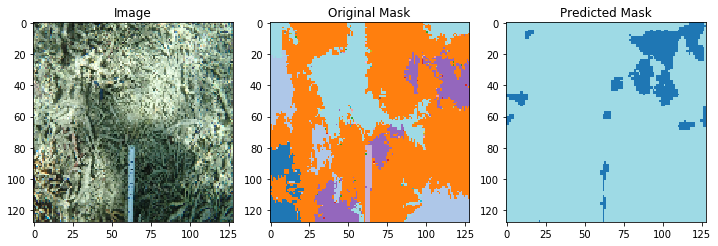

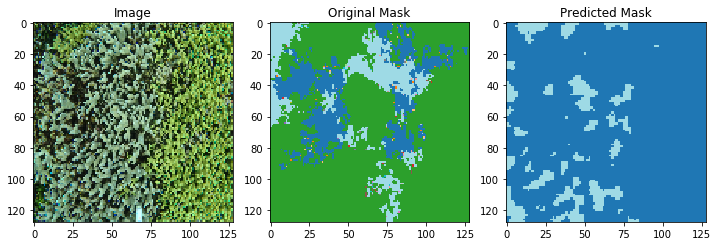

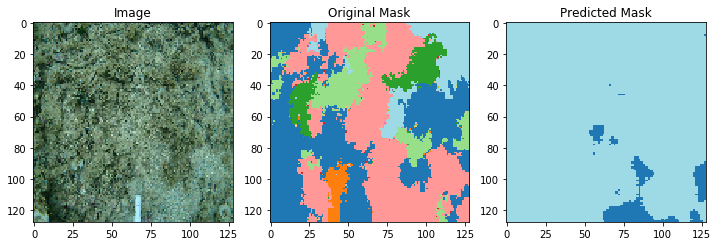

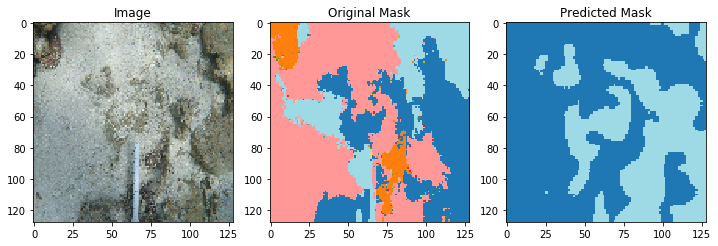

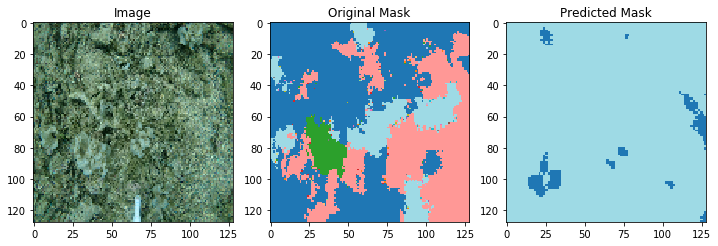

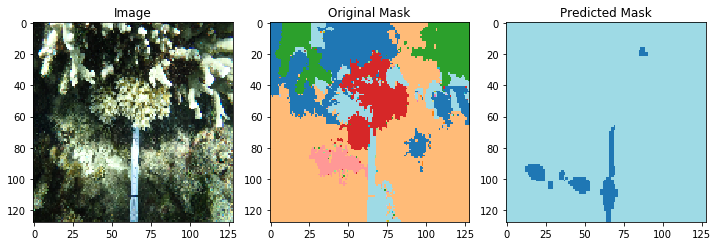

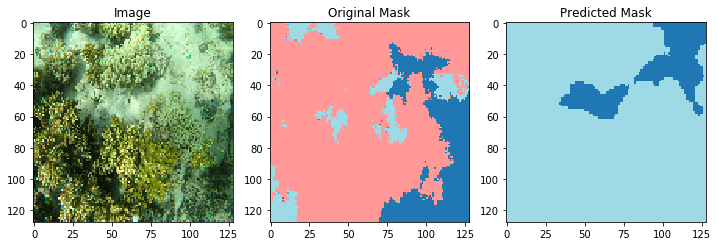

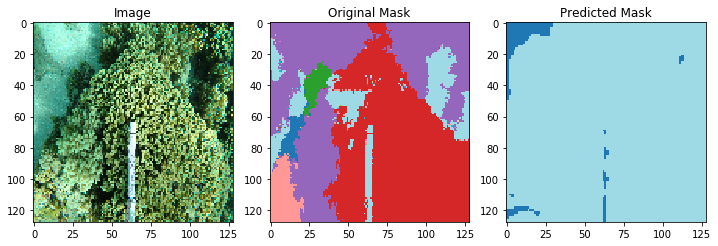

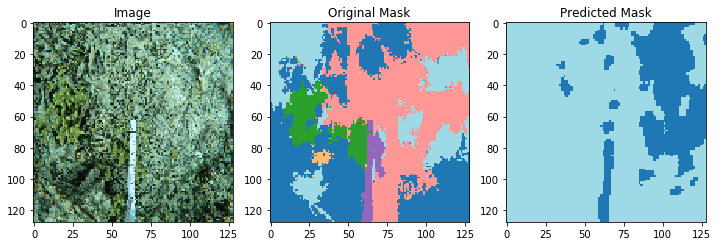

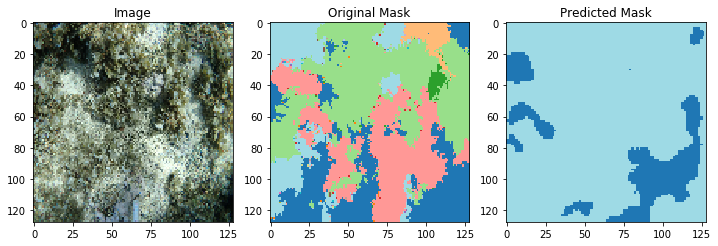

In [55]:
# load the image paths in our testing file and randomly select 10 image paths
print("[INFO] loading up test image paths...")
imagePaths = open(config.TEST_PATHS).read().strip().split("\n")
imagePaths = np.random.choice(imagePaths, size=10)

# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load(config.MODEL_PATH).to(config.DEVICE)

# iterate over the randomly selected test image paths
for path in imagePaths:
    # make predictions and visualize the results
    make_predictions(unet, path)

In [56]:
from imutils import paths
from sklearn.model_selection import train_test_split

# load the image and mask filepaths in a sorted manner
imagePaths = sorted(list(paths.list_images(config.IMAGE_DATASET_PATH)))
maskPaths = sorted(list(paths.list_images(config.MASK_DATASET_PATH)))

# partition the data into training and testing splits using 85% of
# the data for training and the remaining 15% for testing
split = train_test_split(imagePaths, maskPaths, test_size=config.TEST_SPLIT, random_state=42)

# unpack the data split
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]

[INFO] loading up train image paths...
[INFO] load up model...


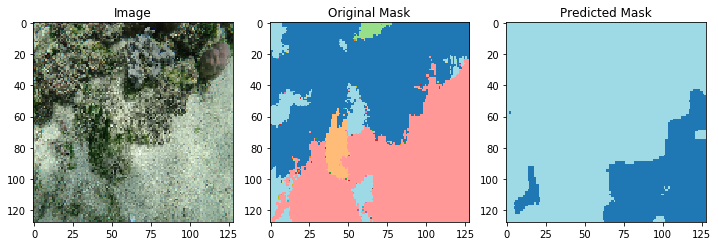

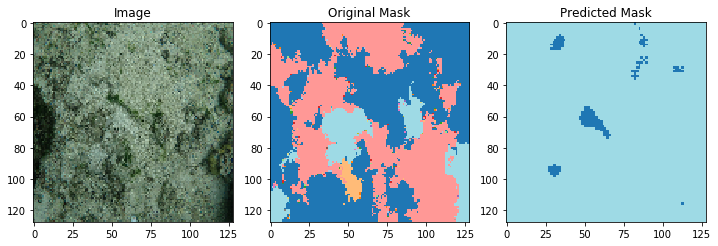

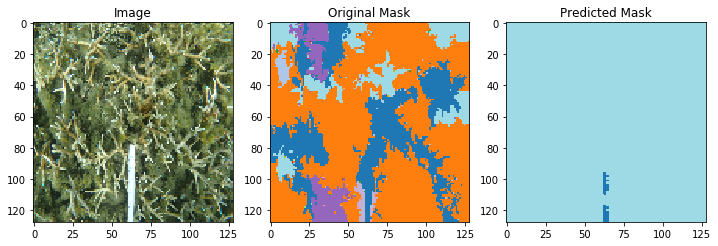

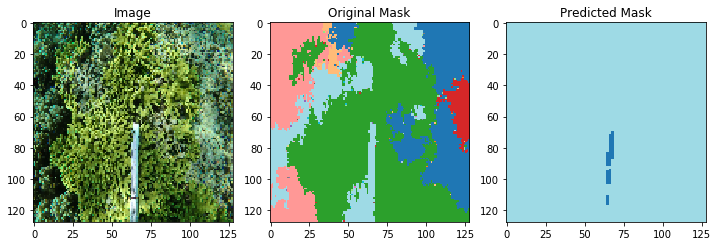

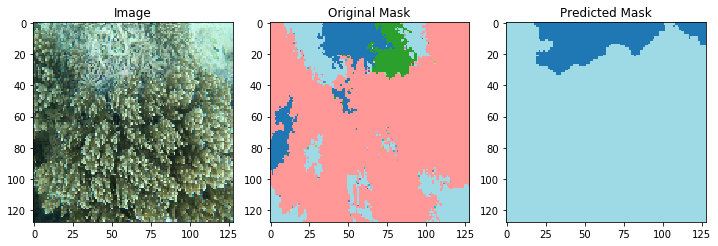

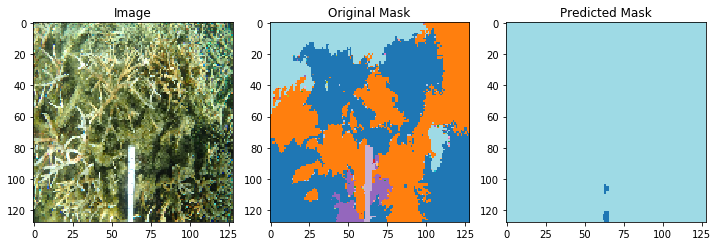

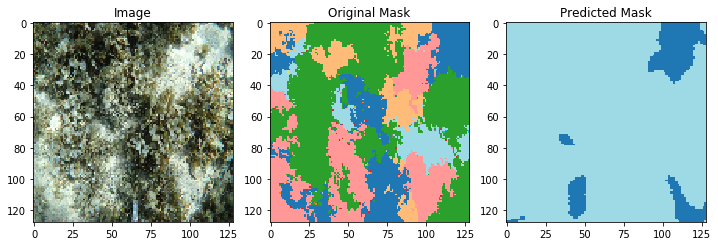

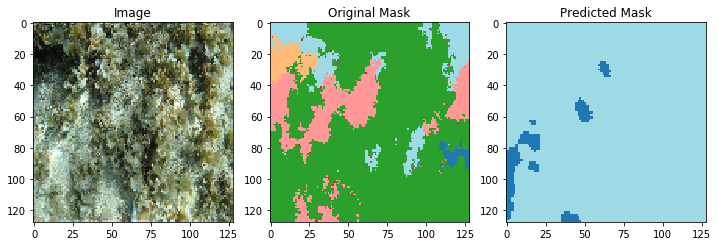

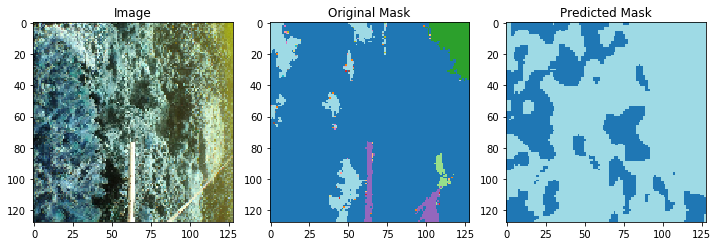

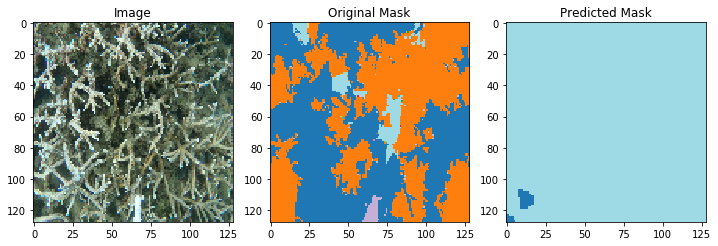

In [57]:
# load the image paths in our testing file and randomly select 10 image paths
print("[INFO] loading up train image paths...")
imagePaths = np.random.choice(trainImages, size=10)

# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load(config.MODEL_PATH).to(config.DEVICE)

# iterate over the randomly selected test image paths
for path in imagePaths:
    # make predictions and visualize the results
    make_predictions(unet, path)